In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import matplotlib.ticker as ticker
import os
import json
import sys
sys.path.append('..')
sys.path.append('../lib')
from lib import *
plt.style.use('../peptidome.mplstyle')
import logging


In [3]:
figdatadir = '../data/Figure Data'
os.listdir(figdatadir)

['mutual_information',
 'nskewfcov_k9_dkls_pairwise.csv',
 'pct_binders_top_500.json',
 'hap_probs.csv',
 'response_vs_distance_non_elispot.csv',
 'epidist.csv',
 'distance_to_self.txt',
 'cijk.csv',
 'malaria_pdf.json',
 'distance_to_self.py',
 'all_assays.csv',
 'distance_to_self.sh',
 'epidist_non_elispot.csv',
 'top_hap_data.csv',
 'malaria_distances.json',
 'pairwise_hamming_distance.py',
 'pairwise_hamming_distance.sh',
 'malaria_abundance_all_assays.csv',
 'diversity_top_500.json',
 'malaria_pdf_all_assays.json',
 'malaria_distances_all_assays.csv',
 'malaria_abundance.csv',
 'response_vs_distance.csv',
 'malaria_distances.csv',
 'coincidence_top_500.json']

### For original analyses that generated the JSONs below see https://github.com/andim/peptidome/blob/master/code/maxent/

In [4]:
with open(f'{figdatadir}/diversity_top_500.json') as d:
    diversity = json.load(d)
    
with open(f'{figdatadir}/pct_binders_top_500.json') as d:
    pct_binders = json.load(d)
    
with open(f'{figdatadir}/coincidence_top_500.json') as d:
    coincidence = json.load(d)

In [5]:
cijk_df = pd.read_csv(f'{figdatadir}/cijk.csv',index_col=0)

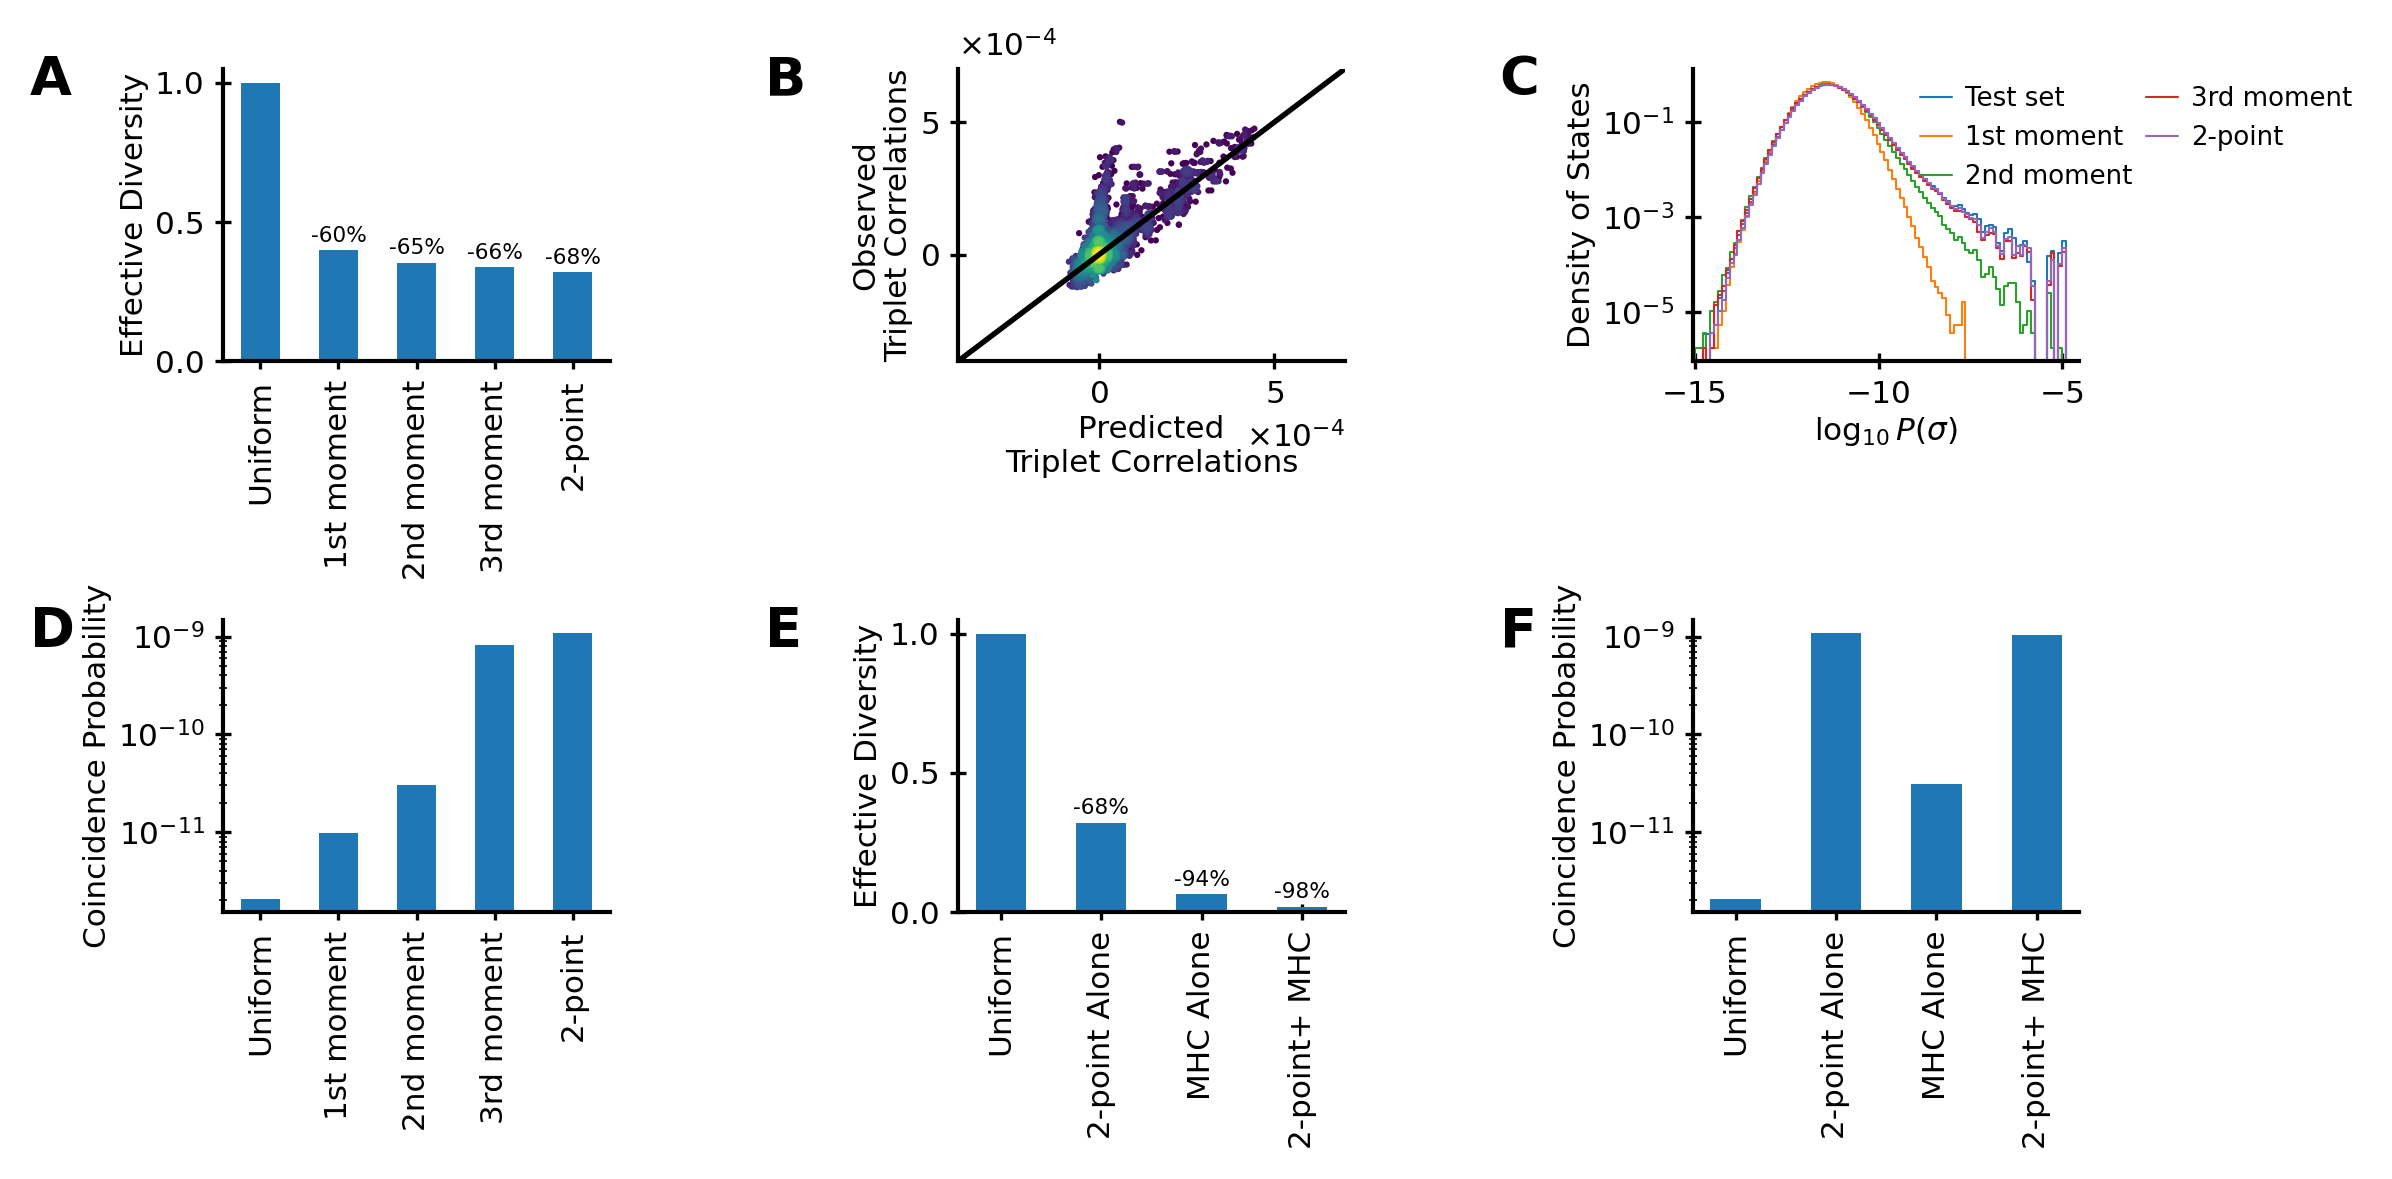

In [6]:
logging.getLogger('matplotlib.font_manager').disabled = True
k = 9
fig, axes = plt.subplots(figsize=(9, 4), ncols=3, nrows=2)

labels_dict = {'uniform' : 'Uniform',
          'independent' : '1st moment',
          'ncov' : '2nd moment',
          'nskew' : '3rd moment',
          'nskewfcov' : '2-point',
          'train' : 'data',
          'test' : 'Test set',
          'uniform HLA': 'uniform HLA'
         }

ax = axes[0,0]
models = ['uniform', 'independent', 'ncov', 'nskew', 'nskewfcov']

data = np.array([diversity[model]['mean'] for model in models])

labels = [labels_dict[model] for model in models]
width = 0.5  # the width of the bars
x = np.arange(len(labels))  # the label locations
rects = ax.bar(x, data, width)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)

reduction = np.abs((data[1:]-data[0])/data[0])
for rect, toplabel in zip(rects[1:], reduction):
    ax.annotate('-{0:.0f}%'.format(100*toplabel),
                xy=(rect.get_x()+width/2, rect.get_height()),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize='xx-small')

ax.set_ylabel('Effective Diversity')

ax = axes[0,1]
lims = (-4e-4, 7e-4)
plotting.density_scatter(cijk_df['model'],cijk_df['test'],norm=colors.LogNorm(vmin=1),s=0.5,bins=50,ax=ax)
ax.set_ylabel('Observed\nTriplet Correlations')
ax.set_xlabel('Predicted\nTriplet Correlations')
ax.plot(lims, lims, 'k')
ax.set_xlim(*lims)
ax.set_ylim(*lims)
ax.ticklabel_format(style='sci', scilimits=(0,0),useMathText=True,useLocale=True)


# ## dos
ax = axes[0, 2]
energies = {}
models = ['test', 'independent', 'ncov', 'nskew', 'nskewfcov']
for model in models:
    energies[model] = np.load(f'../data/generated_data/Human_{model}_k{k}_energies.npz'.format(model=model, k=k))['energies']

xmax = np.log10(np.exp(-min([min(energies[model]) for model in models])-0.05))
xmin = np.log10(np.exp(-max([max(energies[model]) for model in models])+0.05))
nbins = 100
scaley = nbins/(xmax-xmin)
bins = np.linspace(xmin, xmax, num=nbins+1)
kwargs = dict(lw=0.5)
for model in models:
    values = np.exp(-energies[model])
    counts, bins = np.histogram(np.log10(values), bins=bins)
    counts = counts/np.sum(counts)
    ax.step(bins[:-1], counts*scaley, label=labels_dict[model], where='mid', **kwargs)
ax.set_xlabel(r'$\log_{10} P(\sigma)$')
ax.set_xlim(min(bins), max(bins))
ax.set_ylabel('Density of States')
ax.legend(loc='upper right', ncol=2,bbox_to_anchor=(1.75, 1.0))
ax.set_yscale('log')

ax = axes[1,0]
models = ['uniform', 'independent', 'ncov', 'nskew', 'nskewfcov']
data = np.array([coincidence[model]['mean'] for model in models])
labels = [labels_dict[model] for model in models]
width = 0.5
x = np.arange(len(labels))  # the label locations
rects = ax.bar(x, data, width)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('Coincidence Probability')
ax.set_yscale('log')

# data = np.array([pct_binders[model]['mean'] for model in models])
# ste = np.array([pct_binders[model]['ste'] for model in models])
# labels = [labels_dict[model] for model in models]
# width = 0.5
# x = np.arange(len(labels))  # the label locations
# rects = ax.bar(x, data, width,yerr=ste)
# ax.set_xticks(x)
# ax.set_xticklabels(labels, rotation=90)
# ax.set_ylabel('Percentage\nMHC-I Binders')




ax = axes[1,1]


data = np.array([diversity['uniform']['mean'],diversity['nskewfcov']['mean'],diversity['uniform']['mean_mhc'],diversity['nskewfcov']['mean_mhc']])
labels = ['Uniform', labels_dict['nskewfcov']+' Alone', 'MHC Alone', labels_dict['nskewfcov'] + '+ MHC']
width = 0.5  # the width of the bars
x = np.arange(len(labels))  # the label locations
rects = ax.bar(x, data, width)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)

reduction = np.abs((data[1:]-data[0])/data[0])
for rect, toplabel in zip(rects[1:], reduction):
    ax.annotate('-{0:.0f}%'.format(100*toplabel),
                xy=(rect.get_x()+width/2, rect.get_height()),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize='xx-small')
    

ax.set_ylabel('Effective Diversity')


ax = axes[1,2]
data = np.array([coincidence['uniform']['mean'],coincidence['nskewfcov']['mean'],coincidence['uniform']['mean_mhc'],coincidence['nskewfcov']['mean_mhc']])
labels = ['Uniform', labels_dict['nskewfcov']+' Alone', 'MHC Alone', labels_dict['nskewfcov'] + '+ MHC']
width = 0.5  # the width of the bars
x = np.arange(len(labels))  # the label locations
rects = ax.bar(x, data, width)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('Coincidence Probability')
ax.set_yscale('log')


label_axes(fig, labelstyle='%s', xy=(-0.5, 1.05),fontsize=13)
fig.tight_layout(h_pad=.5)
# fig.savefig('../fig1.svg')
# fig.savefig('../fig1.png')

In [7]:
energy_model = {}
energy_test = {}
proteome='Human'
k=9

test_matrix = load_matrix(f'../data/generated_data/{proteome}_test_k{k}_matrix.csv.gz')

for ref_model in ['independent', 'ncov', 'nskew', 'nskewfcov']:


    model_matrix = load_matrix(f'../data/generated_data/{proteome}_{ref_model}_k{k}_matrix.csv.gz')

    params = np.load(f'../data/generated_data/{proteome}_{ref_model}_k{k}_params.npz')

    energy = make_energy(params)

    entropy_df = pd.read_csv(f'../data/generated_data/{proteome}_{ref_model}_k{k}_entropy.csv', header=None, index_col=0)
    F = float(entropy_df.loc['F'])

    energy_model[ref_model] = np.array([energy(x) for x in model_matrix])-F

    energy_test[ref_model] = np.array([energy(x) for x in test_matrix])-F

/tmp/ipykernel_2062324/1924973299.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  F = float(entropy_df.loc['F'])
/tmp/ipykernel_2062324/1924973299.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  F = float(entropy_df.loc['F'])
/tmp/ipykernel_2062324/1924973299.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  F = float(entropy_df.loc['F'])
/tmp/ipykernel_2062324/1924973299.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  F = float(entropy_df.loc['F'])


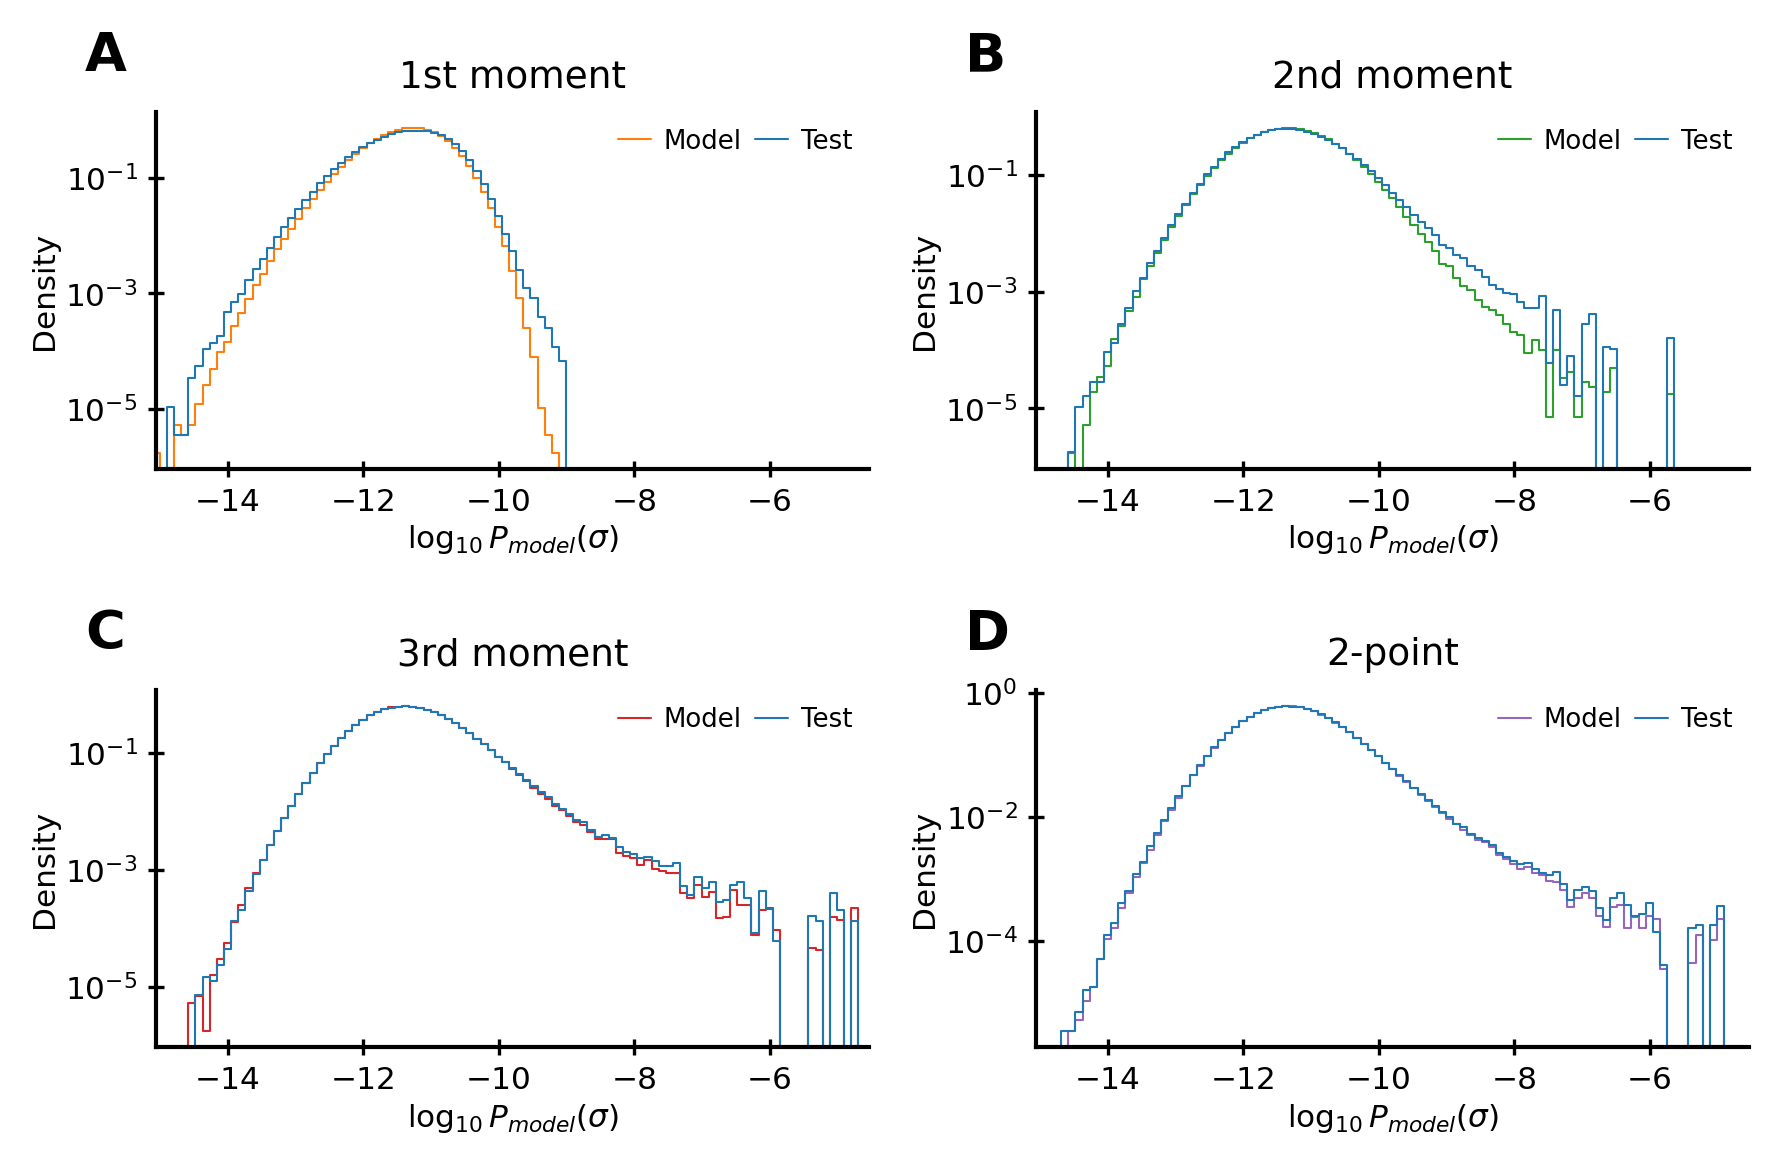

In [13]:
fig, _axes = plt.subplots(figsize=(6, 4), nrows=2, ncols=2)
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
colors = ["tab:orange","tab:green","tab:red","tab:purple"]
axes = _axes.ravel()
for i, model in enumerate(models):
    ax=axes[i]
    nbins = 100
    scaley = nbins/(xmax-xmin)
    bins = np.linspace(xmin, xmax, num=nbins+1)
    kwargs = dict(lw=0.5)
        
    energy_m = energy_model[model]
    energy_t = energy_test[model]
    
    values_m = np.exp(-energy_m)
    values_t = np.exp(-energy_t)
    counts_m, bins_m = np.histogram(np.log10(values_m), bins=bins)
    counts_m = counts_m/np.sum(counts_m)

    counts_t, bins_t = np.histogram(np.log10(values_t), bins=bins)
    counts_t = counts_t/np.sum(counts_t)
    ax.step(bins_m[:-1], counts_m*scaley, label='Model', color=colors[i],where='mid', **kwargs)
    ax.step(bins_t[:-1], counts_t*scaley, label='Test', color='tab:blue',where='mid', **kwargs)
    
    ax.set_xlim(min(bins_m), max(bins_m))
    ax.set_ylabel('Density')
    ax.legend(loc='upper right', ncol=2,bbox_to_anchor=(1, 1.0))
    ax.set_yscale('log')

    ax.set_title(labels_dict[model])
    ax.set_xlabel(r'$\log_{10} P_{model}(\sigma)$')

label_axes(fig, labelstyle='%s', xy=(-0.1, 1.23),fontsize=13)
fig.tight_layout(h_pad=1)
fig.savefig('../figs2_pmodel.png')

In [9]:
counts_t

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.76491636e-07, 3.76491636e-07, 7.52983273e-07, 1.69421236e-06,
       1.88245818e-06, 5.45912873e-06, 1.31772073e-05, 2.03305484e-05,
       4.31082924e-05, 6.81449862e-05, 1.26124698e-04, 1.99728813e-04,
       3.57667055e-04, 5.89209411e-04, 9.32569783e-04, 1.47622371e-03,
       2.27551545e-03, 3.37223559e-03, 4.98926716e-03, 7.28492492e-03,
       1.01449436e-02, 1.38466094e-02, 1.83534025e-02, 2.38012365e-02,
       2.98539043e-02, 3.65355014e-02, 4.30521951e-02, 4.95084619e-02,
       5.52251109e-02, 5.95099623e-02, 6.23961471e-02, 6.38940191e-02,
       6.33356820e-02, 6.12958503e-02, 5.74505530e-02, 5.29951510e-02,
       4.74403934e-02, 4.13598652e-02, 3.52104391e-02, 2.96858008e-02,
       2.44363779e-02, 1.97793646e-02, 1.59596687e-02, 1.27711610e-02,
       1.01197187e-02, 7.91197174e-03, 6.25898521e-03, 5.00564455e-03,
       3.95617411e-03, 3.06012402e-03, 2.46940864e-03, 1.96133318e-03,
      